## **The uncapacitated fixed charge facility location problem**

- Worked on by Weizhe XIE, Bohao XU, Junxin HUANG, Yilin ZHANG

#### **Outline**
1. Problem Description
2. Linear Programming Model
3. Solution Method
    - Heuristic Algorithm
        - ADD Heuristic Algorithm
        - DROP Heuristic Algorithm
    - Heuristic Improvement Algorithms
        - Add + Exchange Heuristic Algorithm
        - Drop + Exchange Heuristic Algorithm
        - Hybrid Heuristic Algorithm
4. Large Instance Generation

#### **Problem Description**

The problem entails selecting optimal locations among 12 nodes to construct facilities, considering each node's demand and construction cost. The objective is to minimize total costs, encompassing both construction and transportation expenses, factored by a given cost per mile.

![截屏2024-03-27 09.05.38.png](<attachment:截屏2024-03-27 09.05.38.png>)
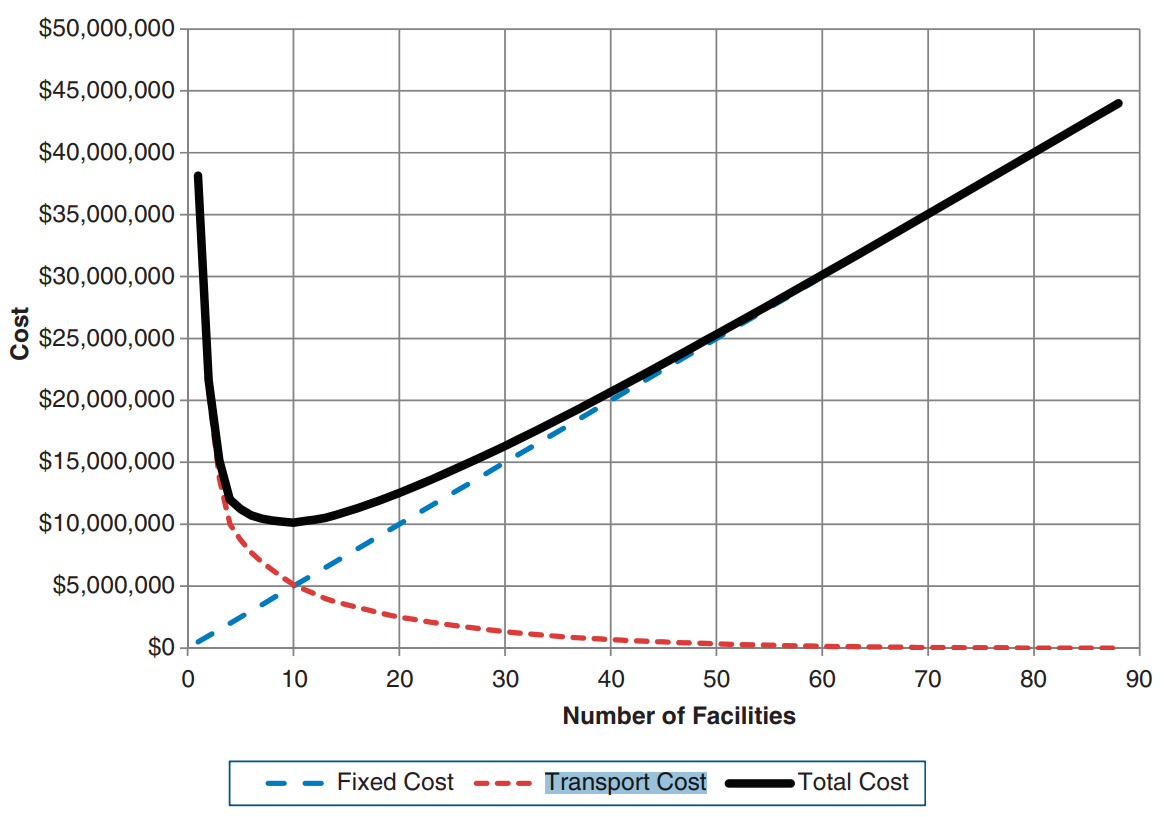
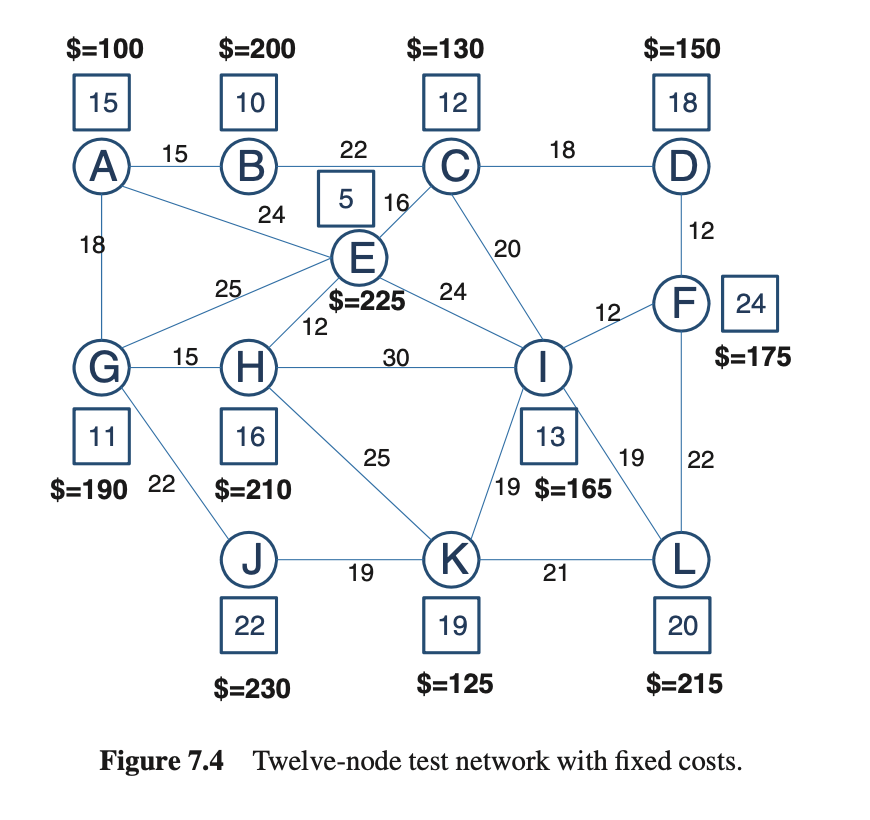

#### **Linear Programming Model**

![截屏2024-03-30 19.12.15.png](<attachment:截屏2024-03-30 19.12.15.png>)
![截屏2024-03-30 19.12.24.png](<attachment:截屏2024-03-30 19.12.24.png>)
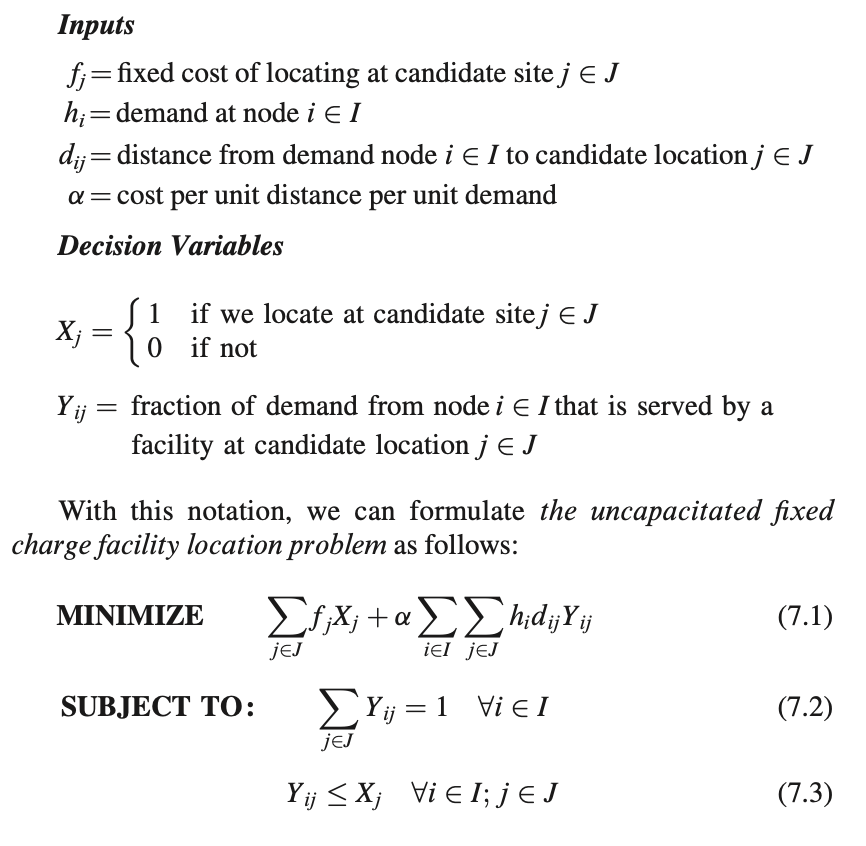
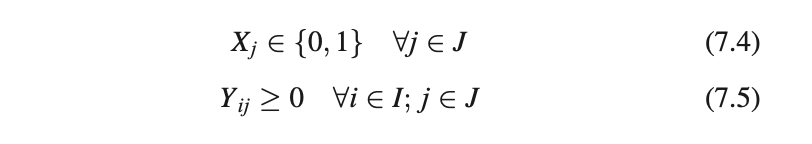

In [32]:
from docplex.mp.model import Model
import numpy as np
import time

In [33]:
inf = np.inf
demand = np.array([15, 10, 12, 18, 5, 24, 11, 16, 13, 22, 19, 20])
f = np.array([100, 200, 130, 150, 225, 175, 190, 210, 165, 230, 125, 215])
distances = np.array([[0, 15, inf, inf, 24, inf, 18, inf, inf, inf, inf, inf],
    [15, 0, 22, inf, inf, inf, inf, inf, inf, inf, inf, inf],
    [inf, 22, 0, 18, 16, inf, inf, inf, 20, inf, inf, inf],
    [inf, inf, 18, 0, inf, 12, inf, inf, inf, inf, inf, inf],
    [24, inf, 16, inf, 0, inf, 25, 12, 24, inf, inf, inf],
    [inf, inf, inf, 12, inf, 0, inf, inf, 12, inf, inf, 22],
    [18, inf, inf, inf, 25, inf, 0, 15, inf, 22, inf, inf],
    [inf, inf, inf, inf, 12, inf, 15, 0, 30, inf, 25, inf],
    [inf, inf, 20, inf, 24, 12, inf, 30, 0, inf, 19, 19],
    [inf, inf, inf, inf, inf, inf, 22, inf, inf, 0, 19, inf],
    [inf, inf, inf, inf, inf, inf, inf, 25, 19, 19, 0, 21],
    [inf, inf, inf, inf, inf, 22, inf, inf, 19, inf, 21, 0]])
alpha = 0.35


In [34]:
def floyd_warshall(G):
    distance = list(map(lambda i: list(map(lambda j: j, i)), G))
    
    # get the number of nodes / list size
    nV = len(G)
    
    # Adding vertices individually
    for k in range(nV):
        for i in range(nV):
            for j in range(nV):
                distance[i][j] = min(distance[i][j], distance[i][k] + distance[k][j])
    return distance

In [35]:
# to calculate currrent cost given some facilities already built
def cal_cost(facilities,initial_distances_demand,distances_demand):
    for i in range(len(f)):
        for j in range(len(f)):
            initial_distances_demand[i][j] = min(distances_demand[i][facilities])
    fix_cost = np.sum(f[facilities])
    var_cost = (np.sum(initial_distances_demand[:,0])*alpha)
    total_cost = fix_cost+var_cost
    return total_cost,initial_distances_demand

In [36]:
distances = floyd_warshall(distances)
distances

[[0.0, 15.0, 37.0, 55.0, 24.0, 60.0, 18.0, 33.0, 48.0, 40.0, 58.0, 67.0],
 [15.0, 0.0, 22.0, 40.0, 38.0, 52.0, 33.0, 48.0, 42.0, 55.0, 61.0, 61.0],
 [37.0, 22.0, 0.0, 18.0, 16.0, 30.0, 41.0, 28.0, 20.0, 58.0, 39.0, 39.0],
 [55.0, 40.0, 18.0, 0.0, 34.0, 12.0, 59.0, 46.0, 24.0, 62.0, 43.0, 34.0],
 [24.0, 38.0, 16.0, 34.0, 0.0, 36.0, 25.0, 12.0, 24.0, 47.0, 37.0, 43.0],
 [60.0, 52.0, 30.0, 12.0, 36.0, 0.0, 57.0, 42.0, 12.0, 50.0, 31.0, 22.0],
 [18.0, 33.0, 41.0, 59.0, 25.0, 57.0, 0.0, 15.0, 45.0, 22.0, 40.0, 61.0],
 [33.0, 48.0, 28.0, 46.0, 12.0, 42.0, 15.0, 0.0, 30.0, 37.0, 25.0, 46.0],
 [48.0, 42.0, 20.0, 24.0, 24.0, 12.0, 45.0, 30.0, 0.0, 38.0, 19.0, 19.0],
 [40.0, 55.0, 58.0, 62.0, 47.0, 50.0, 22.0, 37.0, 38.0, 0.0, 19.0, 40.0],
 [58.0, 61.0, 39.0, 43.0, 37.0, 31.0, 40.0, 25.0, 19.0, 19.0, 0.0, 21.0],
 [67.0, 61.0, 39.0, 34.0, 43.0, 22.0, 61.0, 46.0, 19.0, 40.0, 21.0, 0.0]]

In [37]:
def LP(f, h, d, alpha):

    LP = Model('Linear programming')

    # Decision variables
    X = {}
    for j in range(len(f)):
        X[j] = LP.binary_var(name=f"X_{j}")

    Y = {}
    for i in range(len(f)):
        for j in range(len(f)):
            Y[(i, j)] = LP.continuous_var(name=f"Y_{i}_{j}", lb=0)

    # Objective function
    LP.minimize(LP.sum(f[j] * X[j] for j in range(len(f))) +
                alpha * LP.sum(h[i] * d[i][j] * Y[(i, j)] for i in range(len(f)) for j in range(len(f))))

    # Constraints
    for i in range(len(f)):
        LP.add_constraint(LP.sum(Y[(i, j)] for j in range(len(f))) == 1)

    for i in range(len(f)):
        for j in range(len(f)):
            LP.add_constraint(X[j] >= Y[(i, j)])

    # Solve the model
    start_time = time.time()
    solution = LP.solve(log_output=False)
    end_time = time.time()
    facilities = [j for j in range(len(f)) if X[j].solution_value == 1]
    nodes = [chr(65 + j) for j in range(len(f)) if X[j].solution_value == 1]
    cpu_time=end_time-start_time
    objective_value=solution.get_objective_value()

    # Print solution and objective value
    print(facilities)
    print("Open facilities at nodes", nodes)
    print("Objective value:", objective_value)
    print("cpu time", cpu_time)

    # Return solution
    return facilities, nodes, objective_value, cpu_time


In [38]:
s_LP_facilities, s_LP_nodes, s_LP_objective_value, s_LP_cpu_time = LP(f, demand, distances, alpha)

[0, 3, 10]
Open facilities at nodes ['A', 'D', 'K']
Objective value: 1234.9499999999998
cpu time 0.01600027084350586


#### **Solution Method**
##### 1. ADD Heuristic Algorithm 

![截屏2024-03-31 19.30.19.png](<attachment:截屏2024-03-31 19.30.19.png>)
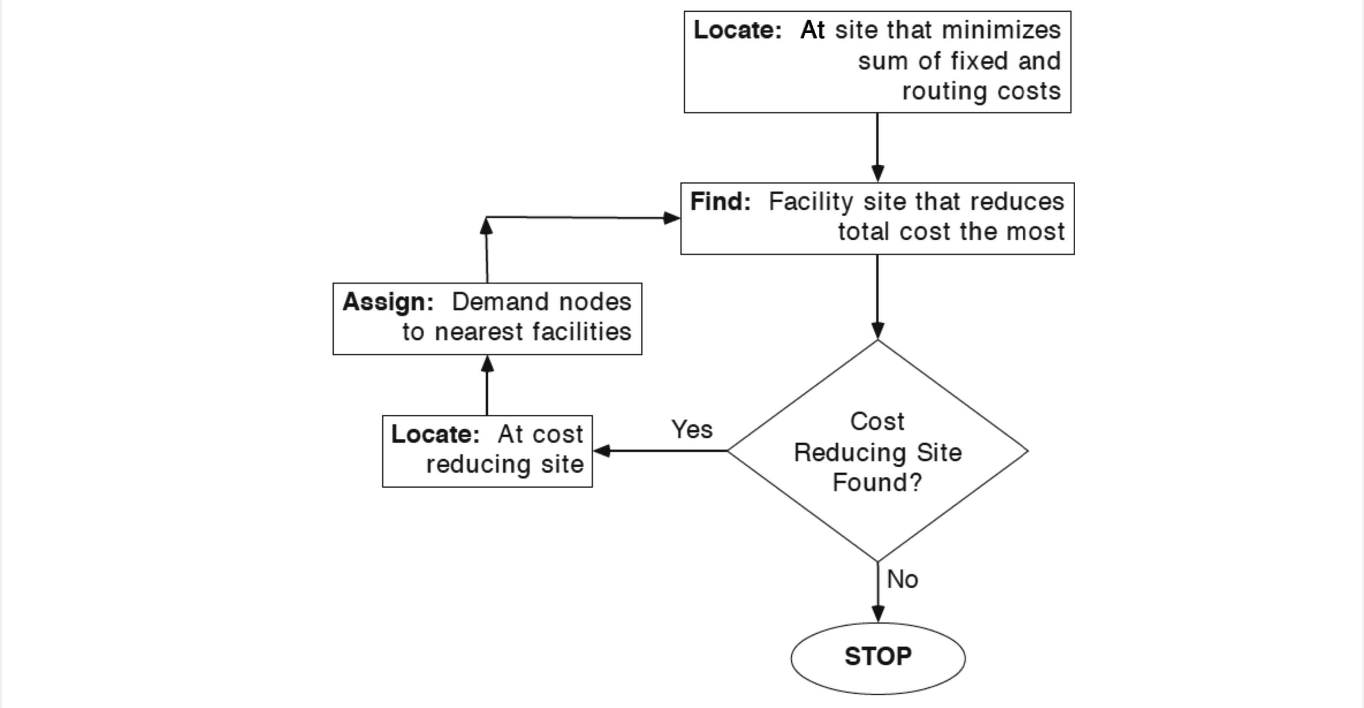

![截屏2024-03-31 19.23.38.png](<attachment:截屏2024-03-31 19.23.38.png>)
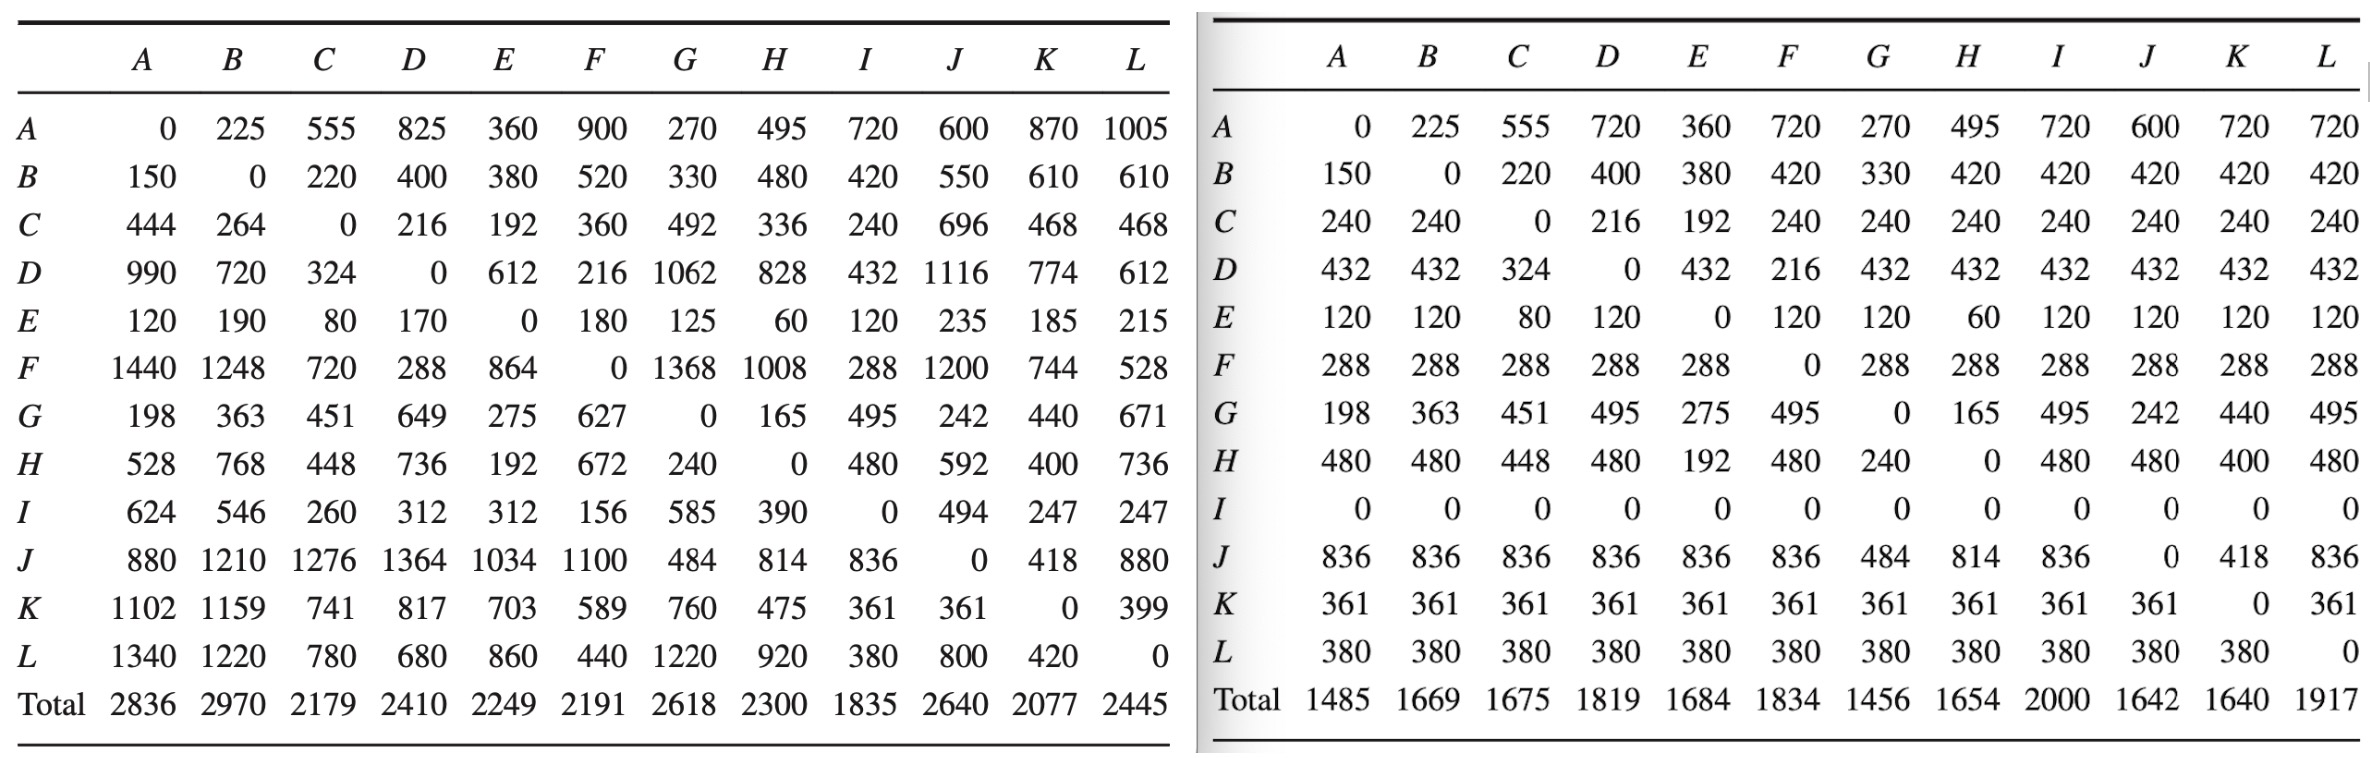
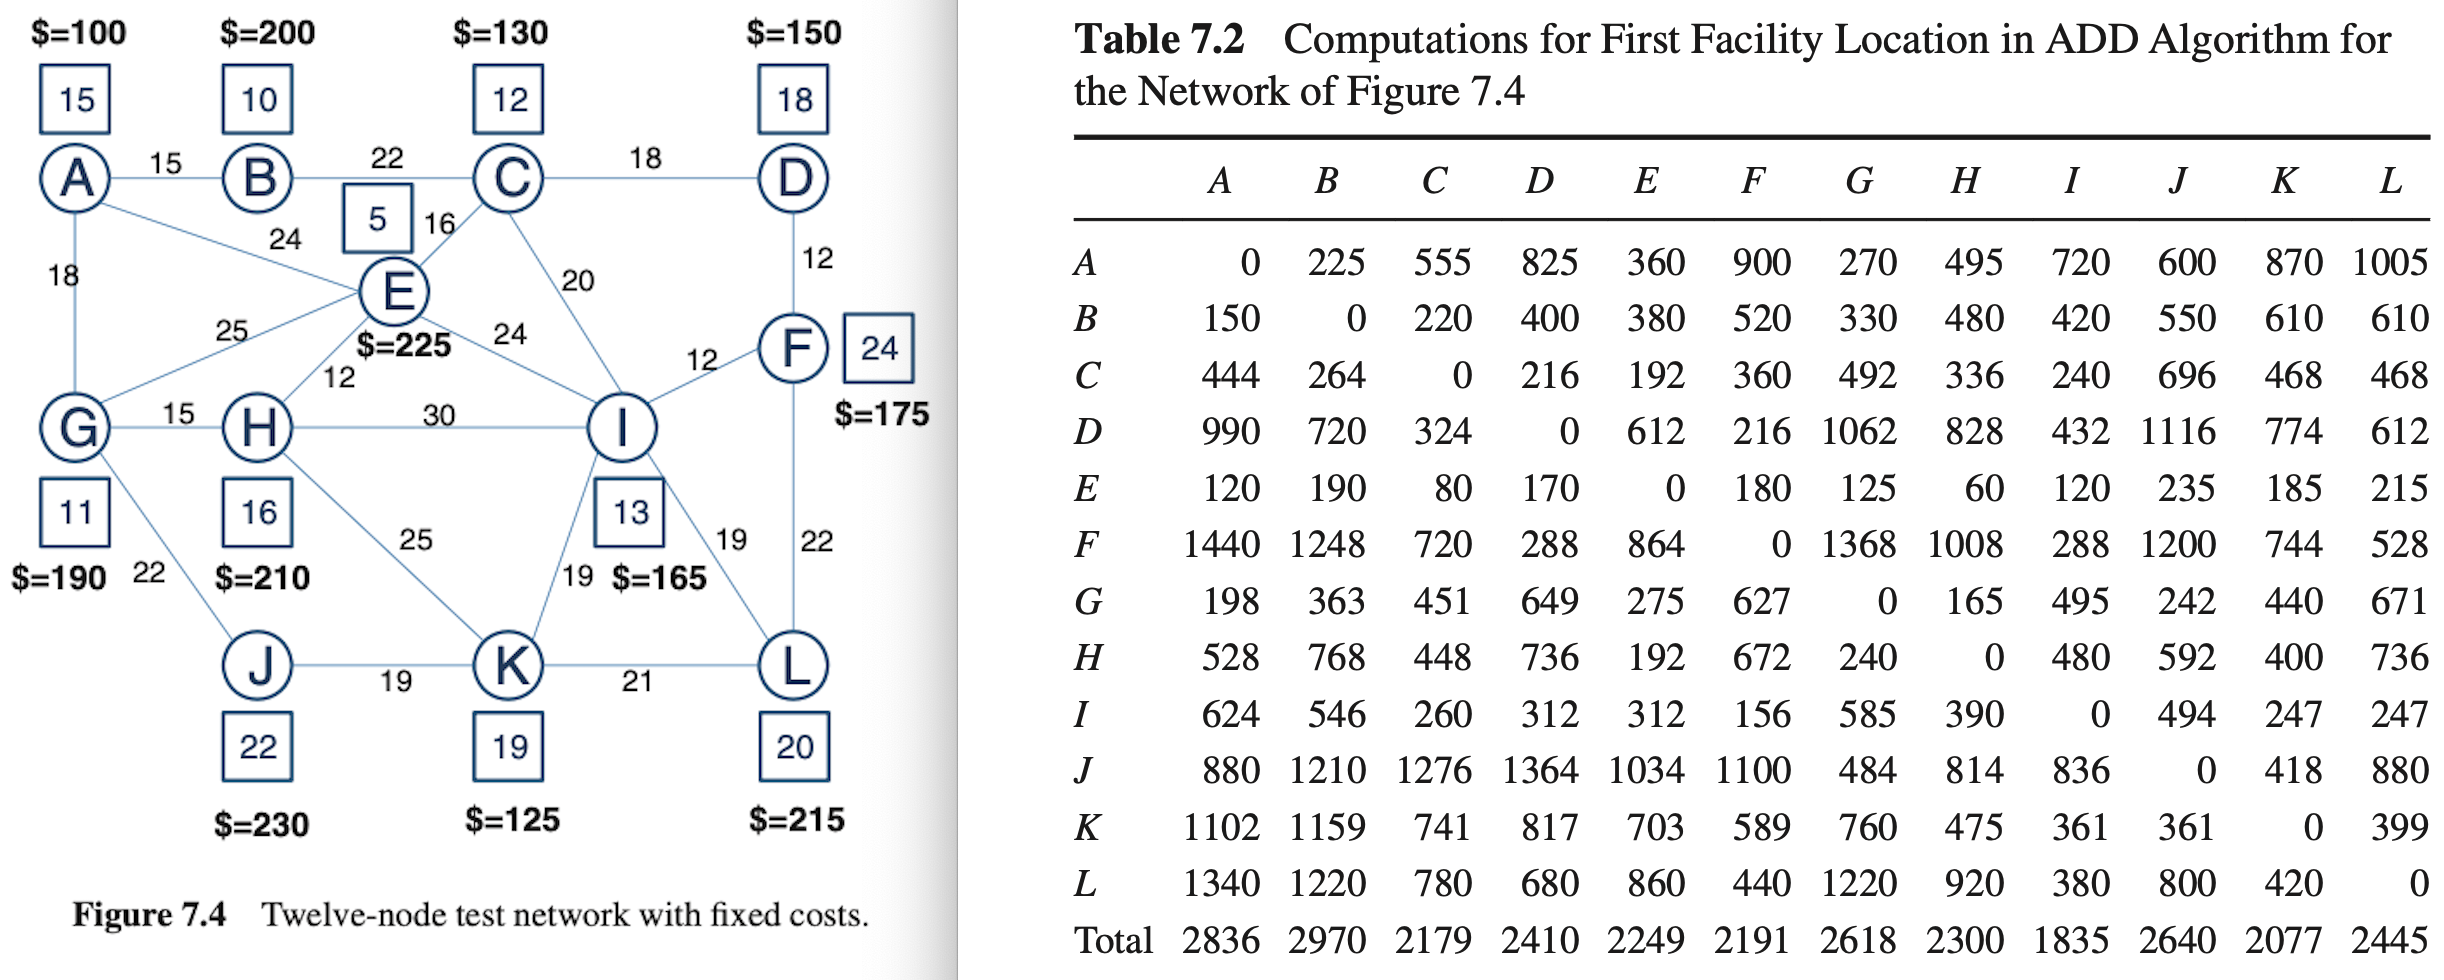

In [39]:
demand = demand[:, np.newaxis]
distances_demand = distances * demand
distances_demand

array([[   0.,  225.,  555.,  825.,  360.,  900.,  270.,  495.,  720.,
         600.,  870., 1005.],
       [ 150.,    0.,  220.,  400.,  380.,  520.,  330.,  480.,  420.,
         550.,  610.,  610.],
       [ 444.,  264.,    0.,  216.,  192.,  360.,  492.,  336.,  240.,
         696.,  468.,  468.],
       [ 990.,  720.,  324.,    0.,  612.,  216., 1062.,  828.,  432.,
        1116.,  774.,  612.],
       [ 120.,  190.,   80.,  170.,    0.,  180.,  125.,   60.,  120.,
         235.,  185.,  215.],
       [1440., 1248.,  720.,  288.,  864.,    0., 1368., 1008.,  288.,
        1200.,  744.,  528.],
       [ 198.,  363.,  451.,  649.,  275.,  627.,    0.,  165.,  495.,
         242.,  440.,  671.],
       [ 528.,  768.,  448.,  736.,  192.,  672.,  240.,    0.,  480.,
         592.,  400.,  736.],
       [ 624.,  546.,  260.,  312.,  312.,  156.,  585.,  390.,    0.,
         494.,  247.,  247.],
       [ 880., 1210., 1276., 1364., 1034., 1100.,  484.,  814.,  836.,
           0.,  418.

In [40]:
# The function for updating distance-graph during ADD-process
def add_update_distance(facilities,distance):
    # for each already exsiting facilities
    for p in range(len(facilities)):
        # for each point in demand_distance graph
        for i in range(len(f)):
            for j in range(len(f)):
                # if we can find a better nearer facility, then revise the demand_distance graph
                if distance[i][j] > distance[i][facilities[p]]:
                    distance[i][j] = distance[i][facilities[p]]
    return distance

In [41]:
def add(facilities,initial_distances_demand,min_cost):
    fix_cost = np.sum(f[facilities])
    previous_cost = min_cost
    while True:
        # find the index of the node with smallest total_cost
        index = np.argmin(np.sum(initial_distances_demand*alpha,axis=0)+np.array(f))
        total_cost = np.min(np.sum(initial_distances_demand*alpha,axis=0)+np.array(f))+fix_cost

        # if no better solution, break
        if total_cost > previous_cost:
            break
        previous_cost = total_cost
        
        # append the new facilities
        facilities.append(index)

        # update current fix_cost
        fix_cost += f[index]

        # print current situation, index_to_letter is a global variable
        nodes = [index_to_letter[key] for key in facilities]
        print("Add node", index_to_letter[index])
        print(f'current nodes: {nodes}')
        print(f'current objective: {total_cost}')

        # update the demand_distance graph, because we built a new facility
        initial_distances_demand = add_update_distance(facilities,initial_distances_demand)

        # display
        print('******************************************************************')
        print(initial_distances_demand)
        print(" ")

    # compute the final min_cost and return it
    min_cost,_ = cal_cost(facilities,distances_demand.copy(),distances_demand)
    
    return facilities,min_cost

In [42]:
# initial variables for running
index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L'}
facilities = []
initial_distances_demand = distances_demand.copy()

# running ADD
s_add_start_time = time.time()
facilities,min_cost = add(facilities,initial_distances_demand,inf)
s_add_end_time = time.time()

# save this variable for final output
add_previous_cost = min_cost 
add_nodes = [index_to_letter[key] for key in facilities]

# compute CPU time
s_add_cpu_time = s_add_end_time - s_add_start_time
print(f'cpu time: {s_add_cpu_time}')

Add node I
current nodes: ['I']
current objective: 1835.1999999999998
******************************************************************
[[  0. 225. 555. 720. 360. 720. 270. 495. 720. 600. 720. 720.]
 [150.   0. 220. 400. 380. 420. 330. 420. 420. 420. 420. 420.]
 [240. 240.   0. 216. 192. 240. 240. 240. 240. 240. 240. 240.]
 [432. 432. 324.   0. 432. 216. 432. 432. 432. 432. 432. 432.]
 [120. 120.  80. 120.   0. 120. 120.  60. 120. 120. 120. 120.]
 [288. 288. 288. 288. 288.   0. 288. 288. 288. 288. 288. 288.]
 [198. 363. 451. 495. 275. 495.   0. 165. 495. 242. 440. 495.]
 [480. 480. 448. 480. 192. 480. 240.   0. 480. 480. 400. 480.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [836. 836. 836. 836. 836. 836. 484. 814. 836.   0. 418. 836.]
 [361. 361. 361. 361. 361. 361. 361. 361. 361. 361.   0. 361.]
 [380. 380. 380. 380. 380. 380. 380. 380. 380. 380. 380.   0.]]
 
Add node G
current nodes: ['I', 'G']
current objective: 1455.75
****************************************

![截屏2024-03-31 19.29.43.png](<attachment:截屏2024-03-31 19.29.43.png>)
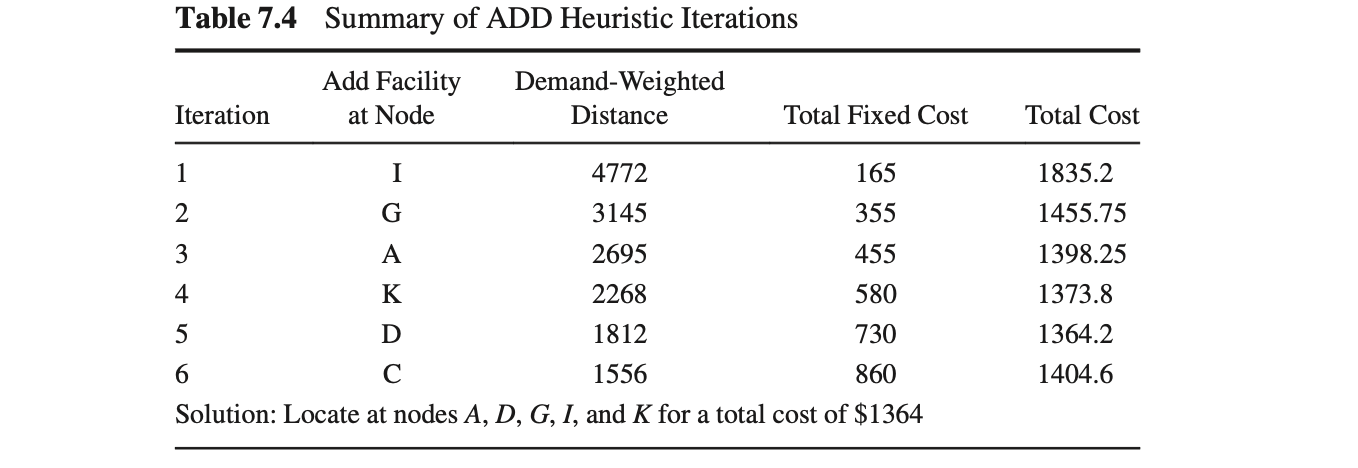

##### 2. DROP Heuristic Algorithm 

![截屏2024-03-31 19.29.09.png](<attachment:截屏2024-03-31 19.29.09.png>)
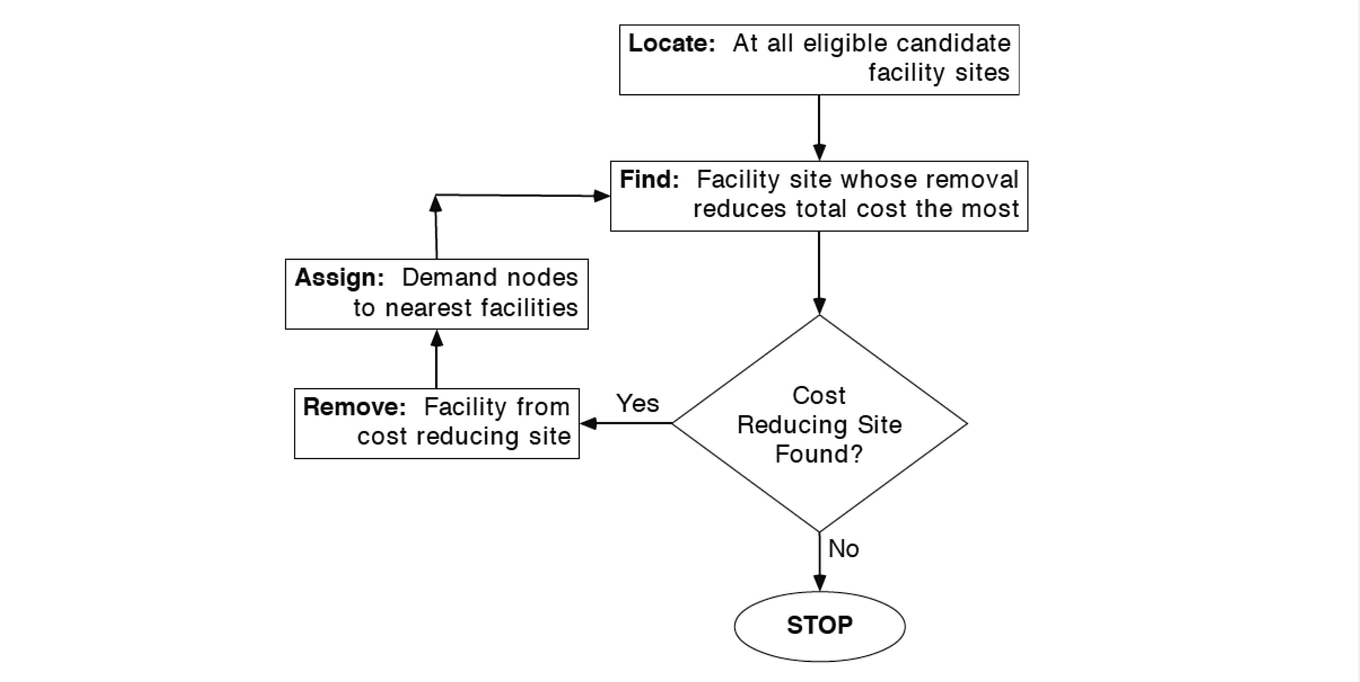

![截屏2024-03-31 19.27.53.png](<attachment:截屏2024-03-31 19.27.53.png>)
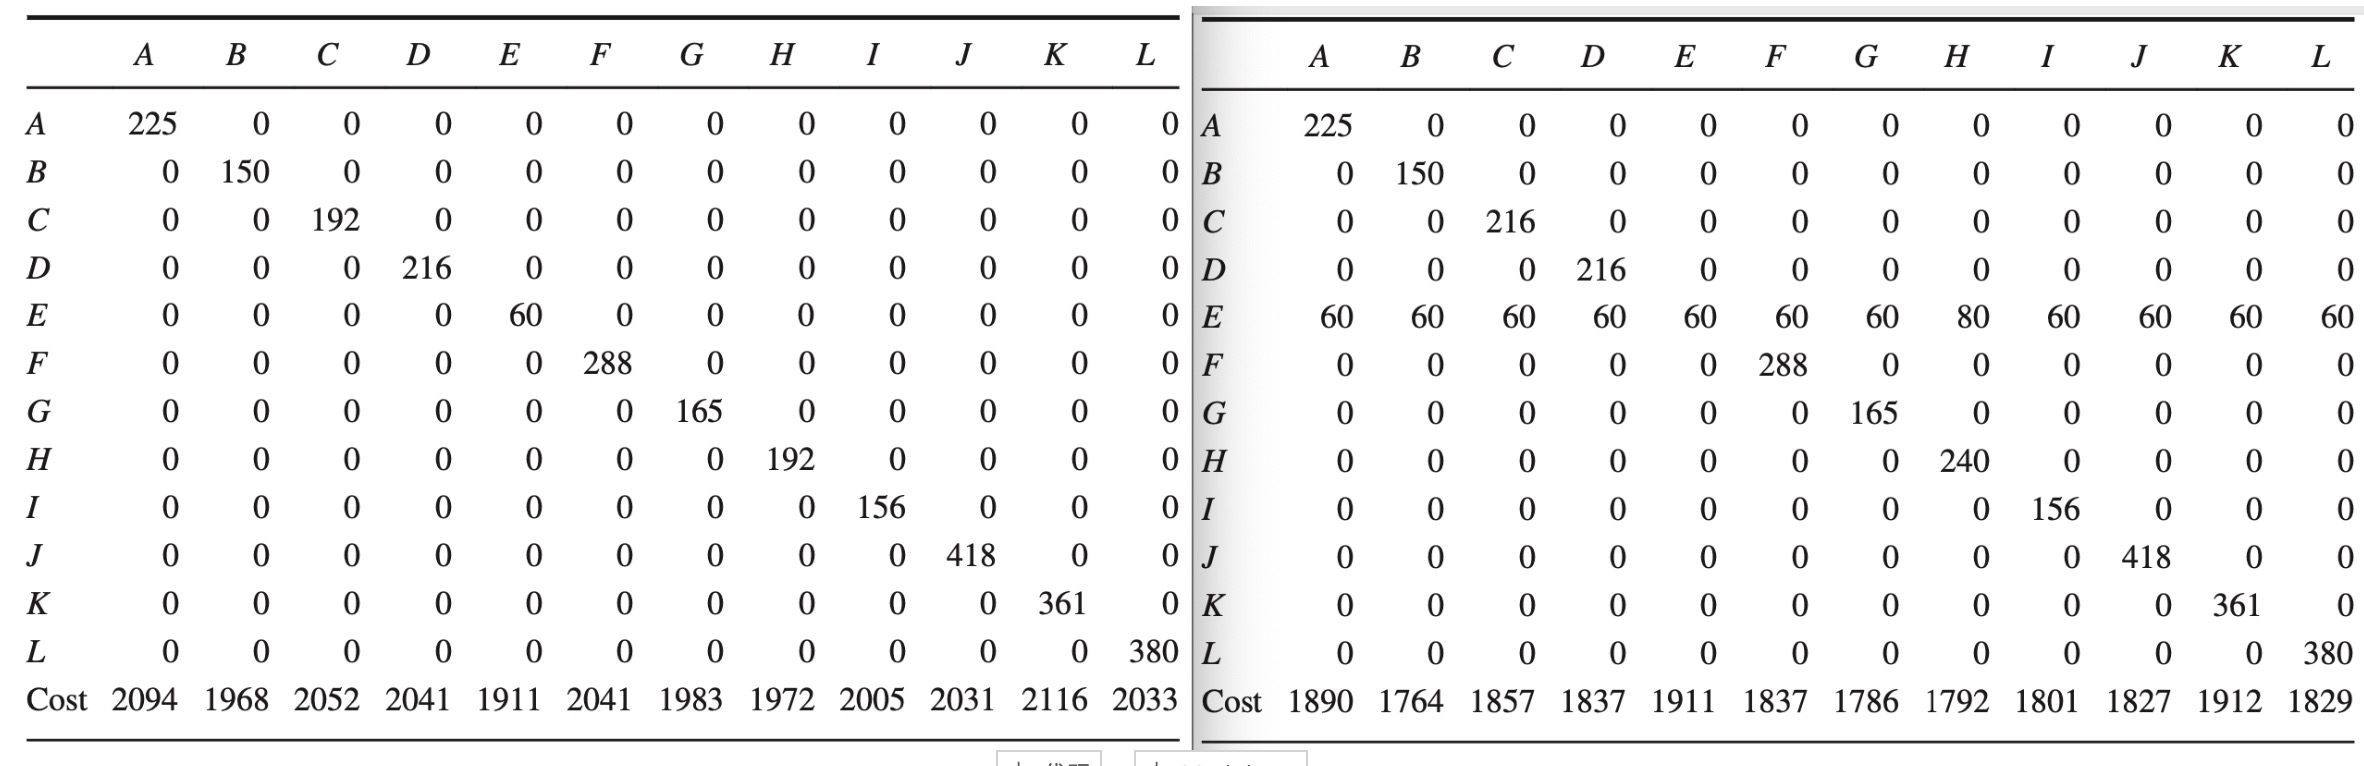
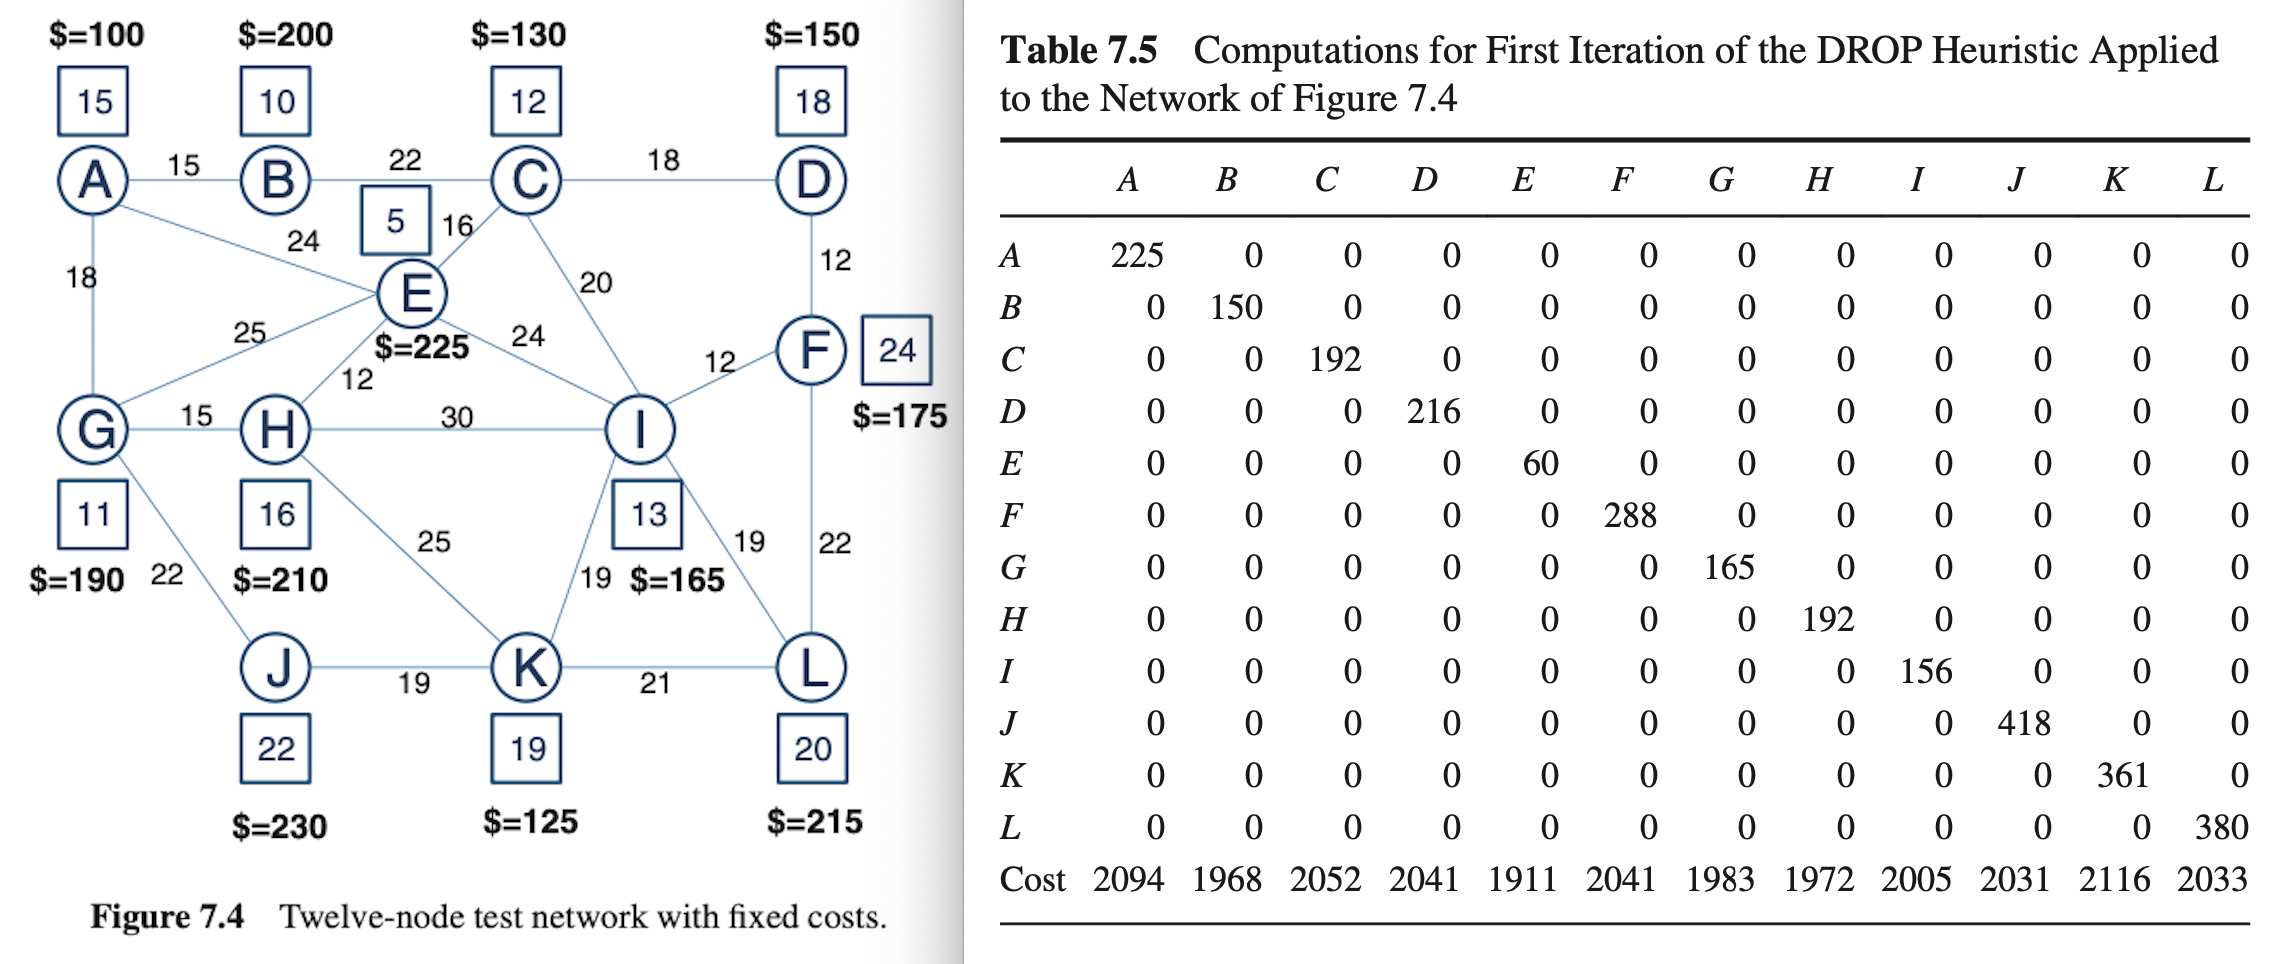

In [43]:
# The function for updating distance-graph during DROP-process
def drop_update_distance(facilities,initial_distances_demand):
    # for each col
    for k in range(len(f)):
        # for each row, then we locate on a specific point
        for i in range(len(f)):
            # index is already exsiting nodes except k, because we are assuming droping k
            index = [v for v in facilities if v != k]
            # for each point on distances_demand graph, we allocate it to its nearest neibor
            initial_distances_demand[i][k] = min(distances_demand[i][index])
    return initial_distances_demand

In [44]:
def drop(facilities,initial_distances_demand,previous_cost,f=f):
    fix_cost = np.sum(f[facilities])
    cala_cost = np.array([cost if idx in facilities else -inf for idx,cost in enumerate(f)],dtype=float)
    while True:
        # update initial distance_demand graph
        initial_distances_demand = drop_update_distance(facilities,initial_distances_demand)

        # find a better solution
        index = np.argmin(np.sum(initial_distances_demand*alpha,axis=0)-cala_cost)
        total_cost = np.min(np.sum(initial_distances_demand*alpha,axis=0)-cala_cost)+fix_cost

        # if no better, break
        if total_cost > previous_cost:
            break
        previous_cost = total_cost
        
        # remove the chosen facility
        facilities.remove(index)
        nodes=[index_to_letter[index] for index in facilities]

        # set the fix_cost of removed facility to -inf, preventing from droping it for twice
        cala_cost[index] = -inf

        # update current fix_cost
        fix_cost -= f[index]

        # display
        print("Drop node", index_to_letter[index])
        print(nodes)
        print(total_cost)
        print('******************************************************************')
        print(initial_distances_demand)
        print(" ")
    min_cost,_ = cal_cost(facilities,distances_demand.copy(),distances_demand)
    return facilities,min_cost

In [45]:
# initialize variables for runing DROP
index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L'}
facilities = [i for i in range(len(f))]
initial_distances_demand = distances_demand.copy()

# run DROP
s_drop_start_time = time.time()
facilities,min_cost = drop(facilities,initial_distances_demand,inf)
s_drop_end_time = time.time()

# save variables for final output
drop_previous_cost = min_cost
s_drop_cpu_time = s_drop_end_time - s_drop_start_time
only_drop_nodes = [index_to_letter[index] for index in facilities]
print(f'cpu time: {s_add_cpu_time}')

Drop node E
['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
1911.0
******************************************************************
[[225.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 150.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 192.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 216.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  60.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 288.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 165.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 192.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 156.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 418.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 361.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 380.]]
 
Drop node B
['A', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
1763.5
*****************************

![截屏2024-03-31 19.31.59.png](<attachment:截屏2024-03-31 19.31.59.png>)
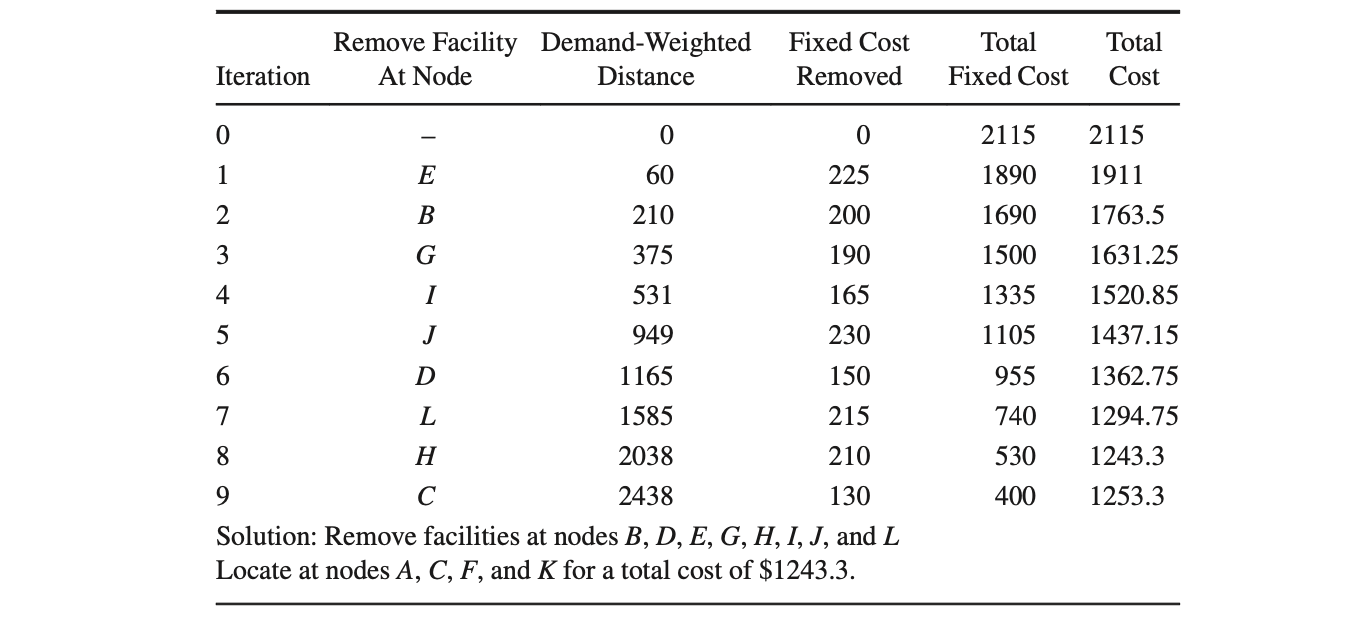

##### 3. Add + Exchange Heuristic Algorithm

![截屏2024-03-31 19.33.16.png](<attachment:截屏2024-03-31 19.33.16.png>)
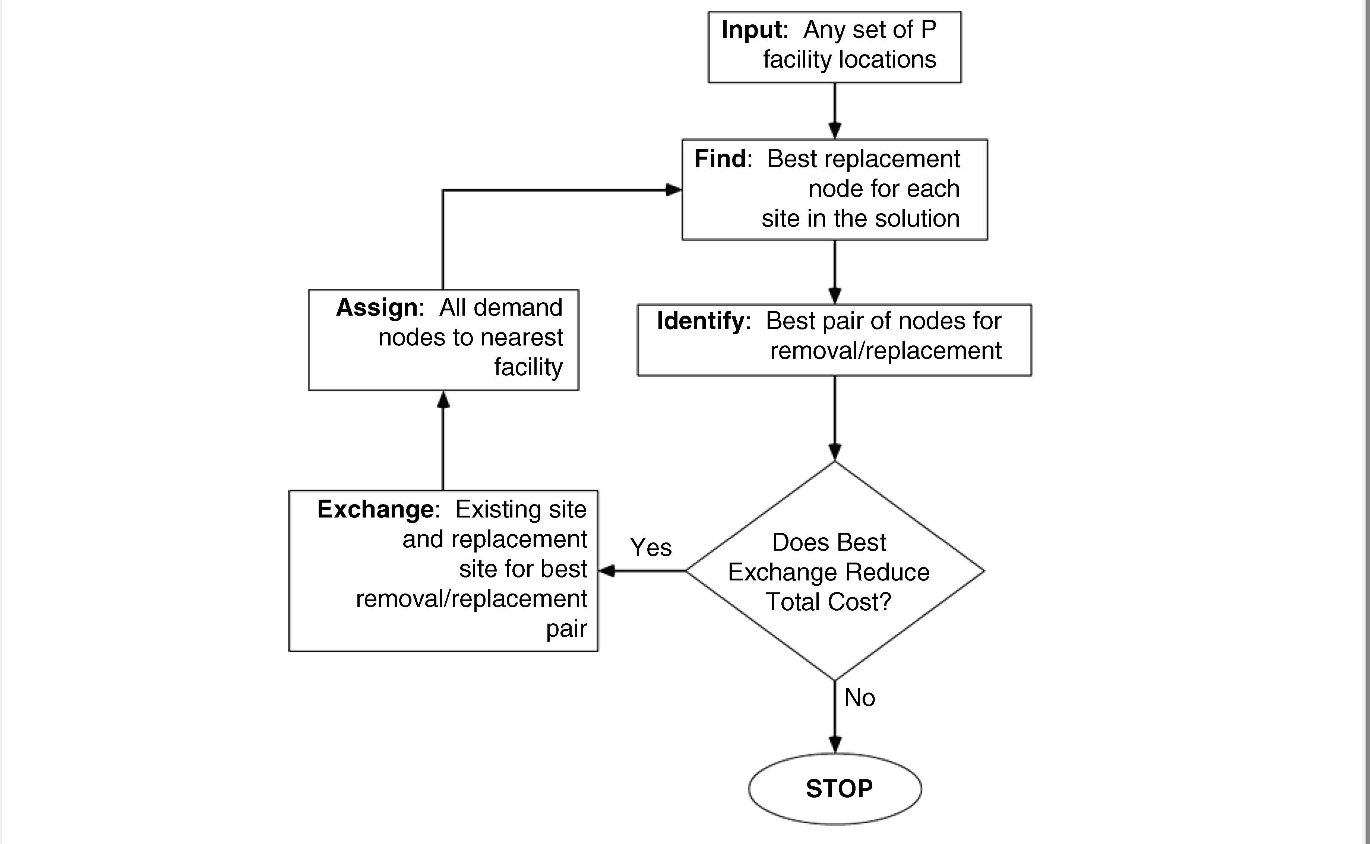

In [46]:
# exchange_nearest_neighbor
def exchange_nb(facilities, total_cost, initial_distances_demand, distances_demand, previous_cpu_time=0.0):
    # copy facilities list, avoiding to revise the original variable
    exchange_facilities = facilities.copy()
    # 
    exchange_nodes = [index_to_letter[index] for index in exchange_facilities]
    no_facilities = [i for i in range(len(f)) if i not in exchange_facilities]
    no_change = True
    total_cost = cal_cost(facilities, initial_distances_demand, distances_demand)[0]
    start_time = time.time()
    print('Start exchange')
    while True: 
        exchange_list = [None] * 2
        found_better_solution = False  

        # for each exsiting facility, we try to exchange it with it nearest_neibor
        for y in exchange_facilities:

            # nb is a dict, which is a global variable
            n = nb[y]

            # generate new_facilities by removing y and append n
            new_facilities = [exchange_facility for exchange_facility in exchange_facilities if exchange_facility != y]
            new_facilities.append(n)

            # calculate total_cost with new_facilities
            new_total_cost, initial_distances_demand = cal_cost(new_facilities, distances_demand.copy(), distances_demand)
            
            # if this solution is better, record it into exchange_list, and update total_cost for next comparation
            if new_total_cost < total_cost:
                exchange_list[0] = y
                exchange_list[1] = n
                total_cost = new_total_cost
                found_better_solution = True
                no_change = False

        # if no better solution, break
        if not found_better_solution:
            break  

        # here, exchange_list records the best exchange_option, so we execute it, and continue interation
        if exchange_list[0] is not None and exchange_list[1] is not None:
            exchange_facilities.remove(exchange_list[0])
            exchange_facilities.append(exchange_list[1])
            no_facilities.remove(exchange_list[1])
            no_facilities.append(exchange_list[0])
            exchange_nodes = [index_to_letter[index] for index in exchange_facilities]
            print("Exchange node", index_to_letter[exchange_list[0]], "by node", index_to_letter[exchange_list[1]])
            print(exchange_nodes)
            print(f'objective: {total_cost}')
            print(initial_distances_demand)
            print('******************************************************************')
            print(' ')

    # record CPU time
    end_time = time.time()
    cpu_time = end_time - start_time + previous_cpu_time

    if no_change:
        print('No change')
    print(f'exchange cpu time:{cpu_time}')

    # calculate final total_cost, and corresponding graph, and return them
    total_cost, initial_distances_demand = cal_cost(exchange_facilities, distances_demand.copy(), distances_demand)
    return no_change, exchange_facilities, exchange_nodes, total_cost, cpu_time, initial_distances_demand

In [47]:
# generally the same with the exchange_nb
def exchange(facilities, total_cost, initial_distances_demand, distances_demand, previous_cpu_time=0.0):
    exchange_facilities = facilities.copy()
    exchange_nodes = [index_to_letter[index] for index in exchange_facilities]
    no_facilities = [i for i in range(len(f)) if i not in exchange_facilities]
    no_change = True
    total_cost = cal_cost(facilities, initial_distances_demand, distances_demand)[0]
    start_time = time.time()
    print('Start exchange')
    while True: 
        exchange_list = [None] * 2
        found_better_solution = False 
        
        # only differences is here
        # for each exisiting faciliti, we use each no_facility to try to exchange
        for y in exchange_facilities:
            for n in no_facilities:
                new_facilities = [exchange_facility for exchange_facility in exchange_facilities if exchange_facility != y]
                new_facilities.append(n)
                new_total_cost, initial_distances_demand = cal_cost(new_facilities, distances_demand.copy(), distances_demand)
                
                if new_total_cost < total_cost:
                    exchange_list[0] = y
                    exchange_list[1] = n
                    total_cost = new_total_cost
                    found_better_solution = True
                    no_change = False

        if not found_better_solution:
            break  

        if exchange_list[0] is not None and exchange_list[1] is not None:
            exchange_facilities.remove(exchange_list[0])
            exchange_facilities.append(exchange_list[1])
            no_facilities.remove(exchange_list[1])
            no_facilities.append(exchange_list[0])
            exchange_nodes = [index_to_letter[index] for index in exchange_facilities]
            print("Exchange node", index_to_letter[exchange_list[0]], "by node", index_to_letter[exchange_list[1]])
            print(exchange_nodes)
            print(f'objective: {total_cost}')
            print(initial_distances_demand)
            print('******************************************************************')
            print(' ')

    end_time = time.time()
    cpu_time = end_time - start_time + previous_cpu_time
    if no_change:
        print('No change')
    print(f'exchange cpu time:{cpu_time}')
    total_cost, initial_distances_demand = cal_cost(exchange_facilities, distances_demand.copy(), distances_demand)
    return no_change, exchange_facilities, exchange_nodes, total_cost, cpu_time, initial_distances_demand


In [48]:
# initialize variables for running
index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L'}
facilities = []
initial_distances_demand = distances_demand.copy()

# running ADD first
start_time = time.time()
facilities,min_cost = add(facilities,initial_distances_demand,inf)
_,initial_distances_demand = cal_cost(facilities,distances_demand.copy(),distances_demand)
end_time = time.time()

# then move to exchange
add_cpu_time = start_time - end_time
s_ae_nochange, s_ae_facilities, s_ae_nodes, s_ae_total_cost, s_ae_cpu_time, s_ae_initial_distances_demand=exchange(facilities, min_cost, initial_distances_demand, distances_demand, add_cpu_time)

Add node I
current nodes: ['I']
current objective: 1835.1999999999998
******************************************************************
[[  0. 225. 555. 720. 360. 720. 270. 495. 720. 600. 720. 720.]
 [150.   0. 220. 400. 380. 420. 330. 420. 420. 420. 420. 420.]
 [240. 240.   0. 216. 192. 240. 240. 240. 240. 240. 240. 240.]
 [432. 432. 324.   0. 432. 216. 432. 432. 432. 432. 432. 432.]
 [120. 120.  80. 120.   0. 120. 120.  60. 120. 120. 120. 120.]
 [288. 288. 288. 288. 288.   0. 288. 288. 288. 288. 288. 288.]
 [198. 363. 451. 495. 275. 495.   0. 165. 495. 242. 440. 495.]
 [480. 480. 448. 480. 192. 480. 240.   0. 480. 480. 400. 480.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [836. 836. 836. 836. 836. 836. 484. 814. 836.   0. 418. 836.]
 [361. 361. 361. 361. 361. 361. 361. 361. 361. 361.   0. 361.]
 [380. 380. 380. 380. 380. 380. 380. 380. 380. 380. 380.   0.]]
 
Add node G
current nodes: ['I', 'G']
current objective: 1455.75
****************************************

![截屏2024-03-31 19.34.35.png](<attachment:截屏2024-03-31 19.34.35.png>)
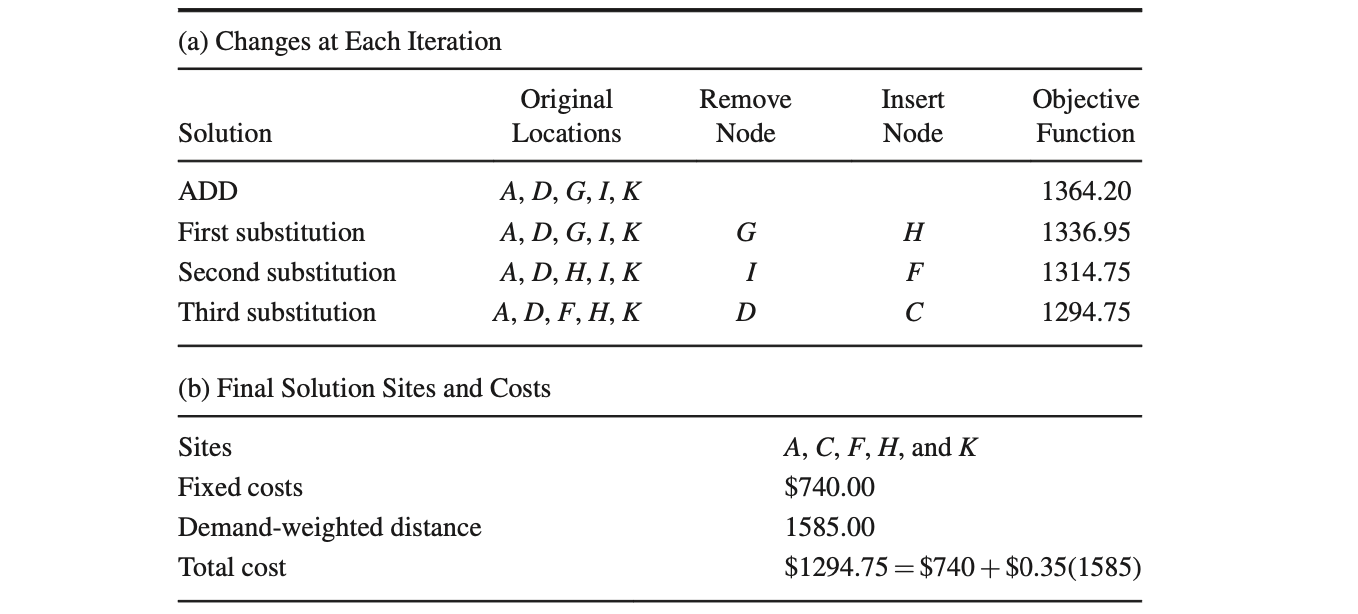

##### 4. Drop + Exchange Heuristic Algorithm

In [49]:
# initialize variables for running
index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L'}
facilities = [i for i in range(len(f))]
initial_distances_demand = distances_demand.copy()

# run DROP first
s_drop_start_time = time.time()
facilities,min_cost = drop(facilities,initial_distances_demand,inf)
s_drop_end_time = time.time()
drop_cpu_time = s_drop_end_time - s_drop_start_time
_,initial_distances_demand = cal_cost(facilities,distances_demand.copy(),distances_demand)

# execute exchange
s_de_nochange, s_de_facilities, s_de_nodes, s_de_total_cost, s_de_cpu_time, s_de_initial_distances_demand=exchange(facilities, min_cost, initial_distances_demand, distances_demand, drop_cpu_time)

Drop node E
['A', 'B', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
1911.0
******************************************************************
[[225.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0. 150.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0. 192.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0. 216.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.  60.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0. 288.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0. 165.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0. 192.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0. 156.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0. 418.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 361.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0. 380.]]
 
Drop node B
['A', 'C', 'D', 'F', 'G', 'H', 'I', 'J', 'K', 'L']
1763.5
*****************************

##### 5. Hybrid Heuristic Algorithm

![截屏2024-03-31 19.35.13.png](<attachment:截屏2024-03-31 19.35.13.png>)
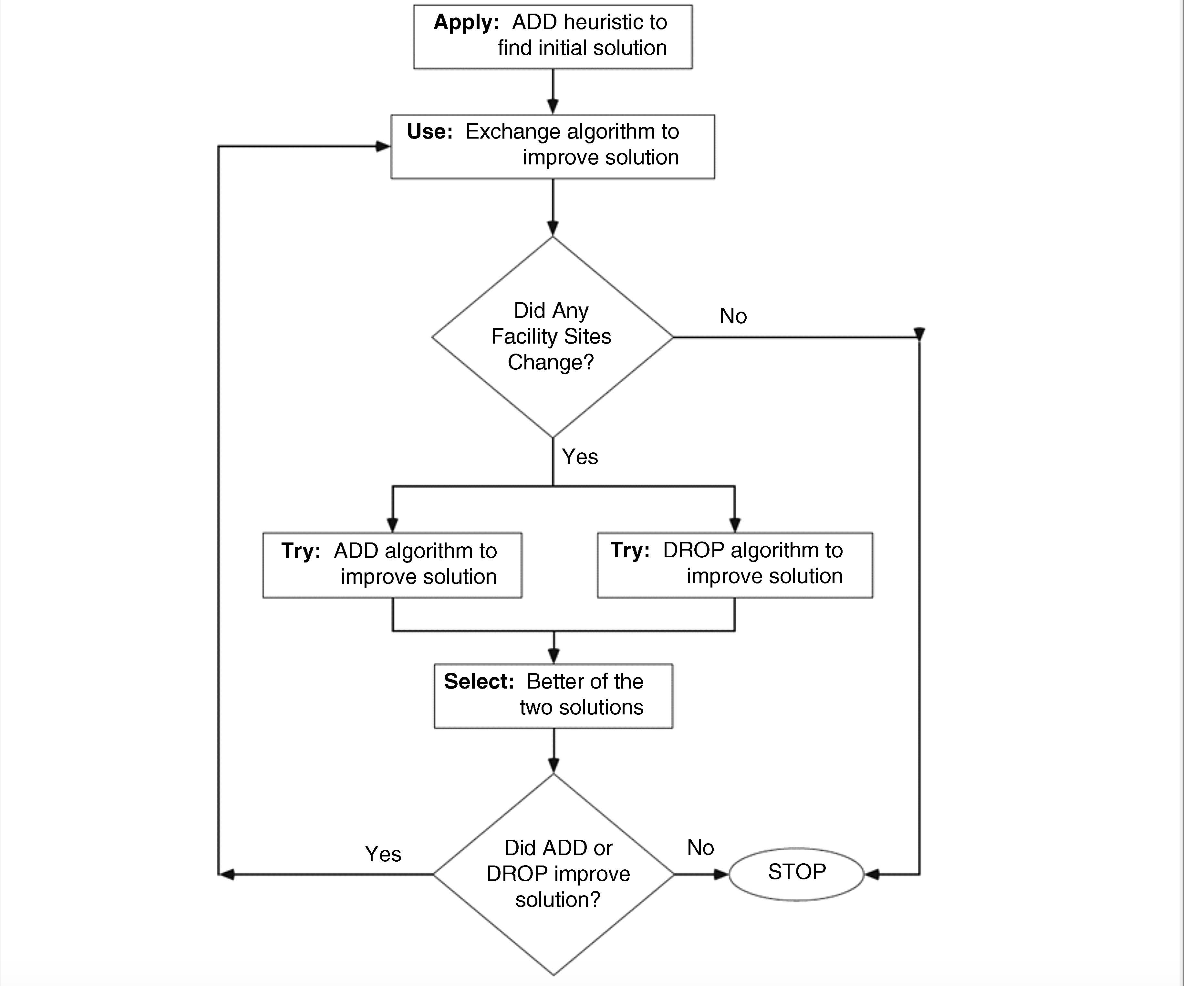

In [50]:
# initialize variables
index_to_letter = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L'}
facilities = []
initial_distances_demand = distances_demand.copy()
print("Add Algorithm")

# run ADD first
facilities,_ = add(facilities,initial_distances_demand,inf)
min_cost,initial_distances_demand = cal_cost(facilities,distances_demand.copy(),distances_demand)


Add Algorithm
Add node I
current nodes: ['I']
current objective: 1835.1999999999998
******************************************************************
[[  0. 225. 555. 720. 360. 720. 270. 495. 720. 600. 720. 720.]
 [150.   0. 220. 400. 380. 420. 330. 420. 420. 420. 420. 420.]
 [240. 240.   0. 216. 192. 240. 240. 240. 240. 240. 240. 240.]
 [432. 432. 324.   0. 432. 216. 432. 432. 432. 432. 432. 432.]
 [120. 120.  80. 120.   0. 120. 120.  60. 120. 120. 120. 120.]
 [288. 288. 288. 288. 288.   0. 288. 288. 288. 288. 288. 288.]
 [198. 363. 451. 495. 275. 495.   0. 165. 495. 242. 440. 495.]
 [480. 480. 448. 480. 192. 480. 240.   0. 480. 480. 400. 480.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [836. 836. 836. 836. 836. 836. 484. 814. 836.   0. 418. 836.]
 [361. 361. 361. 361. 361. 361. 361. 361. 361. 361.   0. 361.]
 [380. 380. 380. 380. 380. 380. 380. 380. 380. 380. 380.   0.]]
 
Add node G
current nodes: ['I', 'G']
current objective: 1455.75
**************************

In [51]:
s_hybrid_start_time = time.time()
while True:
    # run exchange/exchange_nb first
    no_change,facilities,nodes, min_cost, cpu_time,initial_distances_demand = exchange(facilities,min_cost,initial_distances_demand,distances_demand)
    # if no better solution from exchange, break
    if no_change:
        break
    
    # in order to compare ADD and DROP performance, we generate a copy for ADD and DROP seperately, preventing from revise the previous output
    add_facilities = facilities[:]
    add_initial_distances_demand = initial_distances_demand.copy()
    print("Add Algorithm")
    add_facilities,_ = add(add_facilities,add_initial_distances_demand,min_cost)
    add_min_cost,add_initial_distances_demand = cal_cost(add_facilities,distances_demand.copy(),distances_demand)
    print(" ")

    drop_facilities = facilities[:]
    drop_nodes = [index_to_letter[index] for index in drop_facilities]
    drop_initial_distances_demand = initial_distances_demand.copy()
    print("Drop Algorithm")
    drop_facilities,_ = drop(drop_facilities,drop_initial_distances_demand,min_cost,f)
    drop_min_cost,drop_initial_distances_demand = cal_cost(drop_facilities,distances_demand.copy(),distances_demand)
    print(" ")

    # compare the performance of ADD and DROP
    if add_min_cost < drop_min_cost:
        add_drop_facilities = add_facilities
        add_drop_min_cost = add_min_cost
    else:
        add_drop_facilities = drop_facilities
        add_drop_min_cost = drop_min_cost

    # if the better one between ADD and DROP can not exceed the output of exchange, then break
    if add_drop_min_cost == min_cost:
        break 
    
    # update facilities and min_cost for next iteration
    facilities = add_drop_facilities
    min_cost,initial_distances_demand = cal_cost(facilities,distances_demand.copy(),distances_demand)

s_hybrid_end_time = time.time()

s_hybrid_cpu_time = s_hybrid_end_time - s_hybrid_start_time
print(f'hybird cpu time: {s_hybrid_cpu_time}')

Start exchange
Exchange node G by node H
['I', 'A', 'K', 'D', 'H']
objective: 1336.9499999999998
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150. 150.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [432. 432. 432. 432. 432. 432. 432. 432. 432. 432. 432. 432.]
 [120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120. 120.]
 [288. 288. 288. 288. 288. 288. 288. 288. 288. 288. 288. 288.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [240. 240. 240. 240. 240. 240. 240. 240. 240. 240. 240. 240.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [418. 418. 418. 418. 418. 418. 418. 418. 418. 418. 418. 418.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]]
******************************************************************
 
Exchange node I by node F
['A', 'K', 'D', 'H', 'F']
objective: 1314.75
[[  0.

In [52]:
print("Linear programming")
print(s_LP_nodes)
print(s_LP_objective_value)
print("s_LP_cpu_time", s_LP_cpu_time)
print("***********************************")
print("Add Heuristic Algorithms")
print(add_nodes)
print(add_previous_cost)
print("s_add_cpu_time", s_add_cpu_time)
print("***********************************")
print("Drop Heuristic Algorithms")
print(only_drop_nodes)
print(drop_previous_cost)
print("s_drop_cpu_time", s_drop_cpu_time)
print("***********************************")
print("Add + Exchange Algorithms")
print(s_ae_nodes)
print(s_ae_total_cost)
print("s_ae_cpu_time", s_ae_cpu_time)
print("***********************************")
print("Drop + Exchange Algorithms")
print(s_de_nodes)
print(s_de_total_cost)
print("s_de_cpu_time", s_de_cpu_time)
print("***********************************")
print("Hybrid Heuristic Algorithms")
print(nodes)
print(min_cost)
print("s_hybrid_cpu_time", s_hybrid_cpu_time)


Linear programming
['A', 'D', 'K']
1234.9499999999998
s_LP_cpu_time 0.01600027084350586
***********************************
Add Heuristic Algorithms
['I', 'G', 'A', 'K', 'D']
1364.1999999999998
s_add_cpu_time 0.011997222900390625
***********************************
Drop Heuristic Algorithms
['A', 'C', 'F', 'K']
1243.3
s_drop_cpu_time 0.02400064468383789
***********************************
Add + Exchange Algorithms
['A', 'K', 'H', 'F', 'C']
1294.75
s_ae_cpu_time 0.06797218322753906
***********************************
Drop + Exchange Algorithms
['A', 'C', 'F', 'K']
1243.3
s_de_cpu_time 0.04003167152404785
***********************************
Hybrid Heuristic Algorithms
['A', 'K', 'F', 'C']
1243.3
s_hybrid_cpu_time 0.10400056838989258


In [53]:
print("s_LP_cpu_time", s_LP_cpu_time)
print("s_add_cpu_time", s_add_cpu_time)
print("s_drop_cpu_time", s_drop_cpu_time)
print("s_ae_cpu_time", s_ae_cpu_time)
print("s_de_cpu_time", s_de_cpu_time)
print("s_hybrid_cpu_time", s_hybrid_cpu_time)

s_LP_cpu_time 0.01600027084350586
s_add_cpu_time 0.011997222900390625
s_drop_cpu_time 0.02400064468383789
s_ae_cpu_time 0.06797218322753906
s_de_cpu_time 0.04003167152404785
s_hybrid_cpu_time 0.10400056838989258


#### **Large Instance Generation**

In [54]:
'''
Only difference: we do it on the same way as before, but use exchange_neighbror instead of exchange_all
'''

inf = float('inf')
f = np.array([100, 200, 130, 150, 225, 175, 190, 210, 165, 230, 125, 215])
demand = np.array([15, 10, 12, 18, 5, 24, 11, 16, 13, 22, 19, 20])
distances = np.array(
[[0,15,37,55,24,60,18,33,48,40,58,67], 
[15,0,22,40,38,52,33,48,42,55,61,61], 
[37,22,0,18,16,30,41,28,20,58,39,39], 
[55,40,18,0,34,12,59,46,24,62,43,34], 
[24,38,16,34,0,36,25,12,24,47,37,43], 
[60,52,30,12,36,0,57,42,12,50,31,22], 
[18,33,41,59,25,57,0,15,45,22,40,61],
[33,48,28,46,12,42,15,0,30,37,25,46], 
[48,42,20,24,24,12,45,30,0,38,19,19], 
[40,55,58,62,47,50,22,37,38,0,19,40], 
[58,61,39,43,37,31,40,25,19,19,0,21], 
[67,61,39,34,43,22,61,46,19,40,21,0]]
)
alpha = 0.35
index_to_letter = {}
for i in range(200):
    letter_index = i // 26
    letter = chr(65 + (i % 26))
    if letter_index == 0:
        index_to_letter[i] = letter + '1'
    else:
        index_to_letter[i] = letter + str(letter_index + 1)

np.random.seed(0)
f = np.random.randint(100, 300, size=f.size * 10)
demand = np.random.randint(5, 25, size=demand.size * 10)
distances = np.random.randint(15, 70, size=(distances.shape[0] * 10, distances.shape[1] * 10))

**Linear Programming**

In [55]:
l_LP_facilities, l_LP_nodes, l_LP_objective_value, l_LP_cpu_time = LP(f, demand, distances, alpha)

[23, 24, 40, 42, 51, 56, 67, 70, 74, 87, 111]
Open facilities at nodes ['X', 'Y', 'i', 'k', 't', 'y', '\x84', '\x87', '\x8b', '\x98', '°']
Objective value: 11681.05
cpu time 5.128331184387207


**Add Algorithm**

In [56]:
demand = demand[:, np.newaxis]
distances_demand= distances * demand
initial_distances_demand = distances_demand.copy()
nb = {idx: np.argmin(row) for idx,row in enumerate(distances_demand)}

In [57]:
facilities = []
nodes=[]

print("Add Algorithm")
l_add_start_time = time.time()
l_add_facilities,l_add_min_cost = add(facilities,initial_distances_demand,inf)

l_add_min_cost,l_add_initial_distances_demand = cal_cost(l_add_facilities,distances_demand.copy(),distances_demand)
l_add_end_time = time.time()
l_add_cpu_time = l_add_end_time-l_add_start_time

Add Algorithm
Add node J4
current nodes: ['J4']
current objective: 22263.800000000003
******************************************************************
[[ 885  735  735 ...  225  345  450]
 [ 540 1224  468 ...  612  486  594]
 [ 357  357  357 ...  315  357  357]
 ...
 [ 432  384  336 ...  204  240  372]
 [ 348  300  228 ...  756  576  312]
 [ 174  156  174 ...  174  156  174]]
 
Add node G3
current nodes: ['J4', 'G3']
current objective: 16985.55
******************************************************************
[[510 510 510 ... 225 345 450]
 [540 558 468 ... 558 486 558]
 [357 357 357 ... 315 357 357]
 ...
 [432 384 336 ... 204 240 372]
 [348 300 228 ... 384 384 312]
 [174 156 174 ... 174 156 174]]
 
Add node I4
current nodes: ['J4', 'G3', 'I4']
current objective: 14918.099999999995
******************************************************************
[[510 510 510 ... 225 345 450]
 [432 432 432 ... 432 432 432]
 [357 357 357 ... 315 357 357]
 ...
 [276 276 276 ... 204 240 276]
 [348 30

******************************************************************
[[405 405 405 ... 225 345 405]
 [306 306 306 ... 306 306 306]
 [357 357 357 ... 315 357 357]
 ...
 [276 276 276 ... 204 240 276]
 [348 300 228 ... 384 384 312]
 [174 156 174 ... 174 156 174]]
 
Add node W3
current nodes: ['J4', 'G3', 'I4', 'O2', 'Z2', 'F3', 'W3']
current objective: 12170.849999999999
******************************************************************
[[225 225 225 ... 225 225 225]
 [306 306 306 ... 306 306 306]
 [357 357 357 ... 315 357 357]
 ...
 [276 276 276 ... 204 240 276]
 [180 180 180 ... 180 180 180]
 [174 156 174 ... 174 156 174]]
 
Add node Q1
current nodes: ['J4', 'G3', 'I4', 'O2', 'Z2', 'F3', 'W3', 'Q1']
current objective: 12016.2
******************************************************************
[[225 225 225 ... 225 225 225]
 [306 306 306 ... 306 306 306]
 [357 357 357 ... 315 357 357]
 ...
 [276 276 276 ... 204 240 276]
 [180 180 180 ... 180 180 180]
 [174 156 174 ... 174 156 174]]
 
Add no

**Drop Algorithm**

In [58]:
facilities = list(range(len(f)))
nodes=[index_to_letter[index] for index in facilities]
print("Drop Algorithm")
l_drop_start_time = time.time()
l_drop_facilities,l_drop_min_cost = drop(facilities,initial_distances_demand,inf,f)

l_drop_min_cost,l_drop_initial_distances_demand = cal_cost(l_drop_facilities,distances_demand.copy(),distances_demand)
l_drop_end_time = time.time()
l_drop_cpu_time = l_drop_end_time-l_drop_start_time

Drop Algorithm
Drop node C2
['A1', 'B1', 'C1', 'D1', 'E1', 'F1', 'G1', 'H1', 'I1', 'J1', 'K1', 'L1', 'M1', 'N1', 'O1', 'P1', 'Q1', 'R1', 'S1', 'T1', 'U1', 'V1', 'W1', 'X1', 'Y1', 'Z1', 'A2', 'B2', 'D2', 'E2', 'F2', 'G2', 'H2', 'I2', 'J2', 'K2', 'L2', 'M2', 'N2', 'O2', 'P2', 'Q2', 'R2', 'S2', 'T2', 'U2', 'V2', 'W2', 'X2', 'Y2', 'Z2', 'A3', 'B3', 'C3', 'D3', 'E3', 'F3', 'G3', 'H3', 'I3', 'J3', 'K3', 'L3', 'M3', 'N3', 'O3', 'P3', 'Q3', 'R3', 'S3', 'T3', 'U3', 'V3', 'W3', 'X3', 'Y3', 'Z3', 'A4', 'B4', 'C4', 'D4', 'E4', 'F4', 'G4', 'H4', 'I4', 'J4', 'K4', 'L4', 'M4', 'N4', 'O4', 'P4', 'Q4', 'R4', 'S4', 'T4', 'U4', 'V4', 'W4', 'X4', 'Y4', 'Z4', 'A5', 'B5', 'C5', 'D5', 'E5', 'F5', 'G5', 'H5', 'I5', 'J5', 'K5', 'L5', 'M5', 'N5', 'O5', 'P5']
33298.1
******************************************************************
[[225 225 225 ... 225 225 225]
 [270 270 270 ... 270 270 270]
 [315 315 315 ... 315 315 315]
 ...
 [180 180 180 ... 180 180 180]
 [180 180 180 ... 180 180 180]
 [ 90  90  90 ...  90 

**Add + Exchange**

In [59]:
l_ae_nochange,l_ae_facilities, l_ae_nodes, l_ae_total_cost, l_ae_cpu_time, l_ae_initial_distances_demand=exchange_nb(l_add_facilities, l_add_min_cost, l_add_initial_distances_demand, distances_demand, l_add_cpu_time)

Start exchange
No change
exchange cpu time:1.3269760608673096


**Drop + Exchange**

In [60]:
l_de_nochange, l_de_facilities, l_de_nodes, l_de_total_cost, l_de_cpu_time, l_de_initial_distances_demand=exchange_nb(l_drop_facilities, l_drop_min_cost, l_drop_initial_distances_demand, distances_demand, l_drop_cpu_time)

Start exchange
Exchange node A3 by node H1
['W1', 'X1', 'O2', 'Q2', 'Z2', 'E3', 'P3', 'W3', 'J4', 'H5', 'H1']
objective: 11724.3
[[225 225 225 ... 225 225 225]
 [378 378 378 ... 378 378 378]
 [357 357 357 ... 357 357 357]
 ...
 [192 192 192 ... 192 192 192]
 [180 180 180 ... 180 180 180]
 [102 102 102 ... 102 102 102]]
******************************************************************
 
exchange cpu time:28.66418695449829


**Hybrid Algorithm**

In [61]:
l_hybrid_start_time = time.time()

facilities = []
nodes=[]
initial_distances_demand = distances_demand.copy()

print("Add Algorithm")
l_add_start_time = time.time()
l_add_facilities,l_add_min_cost = add(facilities,initial_distances_demand,inf)

_,initial_distances_demand = cal_cost(l_add_facilities,distances_demand.copy(),distances_demand)


while True:
    no_change,facilities,nodes, min_cost, cpu_time,initial_distances_demand = exchange_nb(l_add_facilities,l_add_min_cost,initial_distances_demand,distances_demand,l_add_cpu_time)
    if no_change:
        break
    
    add_facilities = facilities[:]
    add_initial_distances_demand = initial_distances_demand.copy()
    print("Add Algorithm")
    add_facilities,add_min_cost = add(add_facilities,add_initial_distances_demand,min_cost)
    print(" ")

    drop_facilities = facilities[:]
    drop_nodes = [index_to_letter[index] for index in drop_facilities]
    drop_initial_distances_demand = initial_distances_demand.copy()
    print("Drop Algorithm")
    drop_facilities,drop_min_cost = drop(drop_facilities,drop_initial_distances_demand,min_cost,f)
    print(" ")

    if add_min_cost < drop_min_cost:
        add_drop_facilities = add_facilities
        add_drop_min_cost = add_min_cost
    else:
        add_drop_facilities = drop_facilities
        add_drop_min_cost = drop_min_cost

    if add_drop_min_cost == min_cost:
        break 

    facilities = add_drop_facilities
    min_cost,initial_distances_demand = cal_cost(facilities,distances_demand.copy(),distances_demand)
l_hybrid_end_time = time.time()
l_hybrid_cpu_time =l_hybrid_end_time-l_hybrid_start_time

Add Algorithm
Add node J4
current nodes: ['J4']
current objective: 22263.800000000003
******************************************************************
[[ 885  735  735 ...  225  345  450]
 [ 540 1224  468 ...  612  486  594]
 [ 357  357  357 ...  315  357  357]
 ...
 [ 432  384  336 ...  204  240  372]
 [ 348  300  228 ...  756  576  312]
 [ 174  156  174 ...  174  156  174]]
 
Add node G3
current nodes: ['J4', 'G3']
current objective: 16985.55
******************************************************************
[[510 510 510 ... 225 345 450]
 [540 558 468 ... 558 486 558]
 [357 357 357 ... 315 357 357]
 ...
 [432 384 336 ... 204 240 372]
 [348 300 228 ... 384 384 312]
 [174 156 174 ... 174 156 174]]
 
Add node I4
current nodes: ['J4', 'G3', 'I4']
current objective: 14918.099999999995
******************************************************************
[[510 510 510 ... 225 345 450]
 [432 432 432 ... 432 432 432]
 [357 357 357 ... 315 357 357]
 ...
 [276 276 276 ... 204 240 276]
 [348 30

In [62]:
print("Linear programming")
print(l_LP_facilities)
print(l_LP_objective_value)
print("l_LP_cpu_time", l_LP_cpu_time)
print("***********************************")
print("Add Heuristic Algorithms")
print(l_add_facilities)
print(l_add_min_cost)
print("l_add_cpu_time", l_add_cpu_time)
print("***********************************")
print("Drop Heuristic Algorithms")
print(l_drop_facilities)
print(l_drop_min_cost)
print("l_drop_cpu_time", l_drop_cpu_time)
print("***********************************")
print("Add + Excahnge Algorithms")
print(l_ae_facilities)
print(l_ae_total_cost)
print("l_ae_cpu_time", l_ae_cpu_time)
print("***********************************")
print("Drop +Exchange Algorithms")
print(l_de_facilities)
print(l_de_total_cost)
print("l_de_cpu_time", l_de_cpu_time)
print("***********************************")
print("Heuristic Improve Algorithms")
print(facilities)
print(min_cost)
print("l_Hybrid_cpu_time", l_hybrid_cpu_time)

Linear programming
[23, 24, 40, 42, 51, 56, 67, 70, 74, 87, 111]
11681.05
l_LP_cpu_time 5.128331184387207
***********************************
Add Heuristic Algorithms
[87, 58, 86, 40, 51, 57, 74, 16, 91, 67, 23]
11870.349999999999
l_add_cpu_time 0.7390754222869873
***********************************
Drop Heuristic Algorithms
[22, 23, 40, 42, 51, 52, 56, 67, 74, 87, 111]
11728.65
l_drop_cpu_time 27.540356159210205
***********************************
Add + Excahnge Algorithms
[87, 58, 86, 40, 51, 57, 74, 16, 91, 67, 23]
11870.349999999999
l_ae_cpu_time 1.3269760608673096
***********************************
Drop +Exchange Algorithms
[22, 23, 40, 42, 51, 56, 67, 74, 87, 111, 7]
11724.3
l_de_cpu_time 28.66418695449829
***********************************
Heuristic Improve Algorithms
[87, 58, 86, 40, 51, 57, 74, 16, 91, 67, 23]
11870.349999999999
l_Hybrid_cpu_time 1.2811107635498047



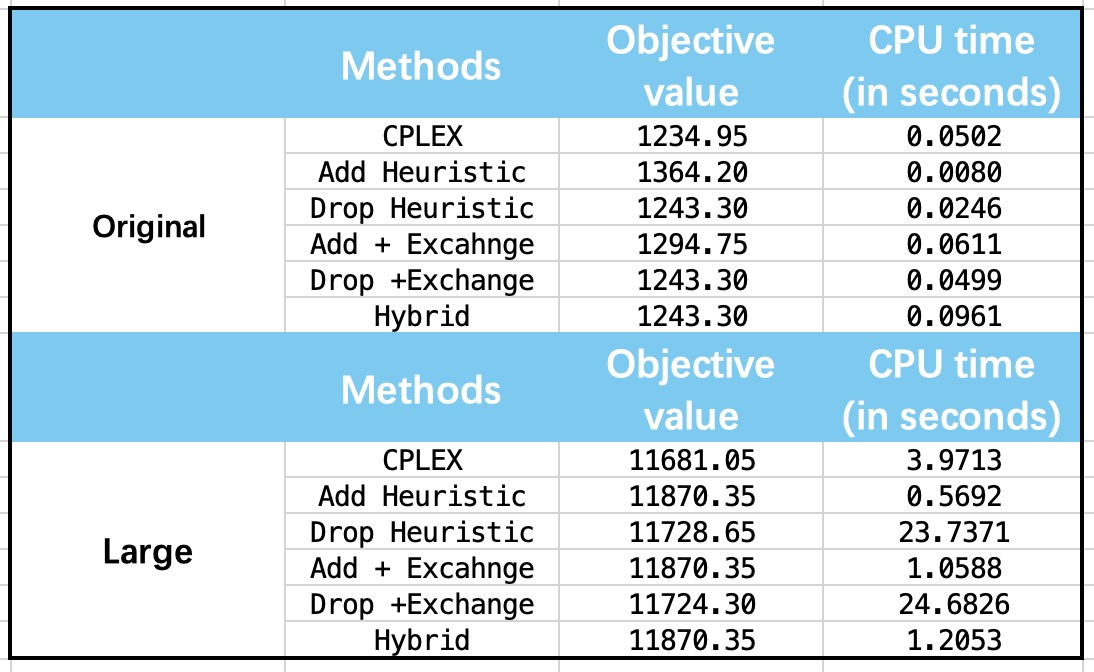